Implement a classification script based on the fine tuning of a neural network for the 101 object classes dataset, following the guidelines shown in the notebook.

Verify the impact over the model performance given by:

1.   A different architecture (i.e. no mobile net)
2.   Data augmentation operations




In [ ]:
from tensorflow import keras
keras.__version__

'2.4.0'

In [ ]:
from tensorflow.keras.applications import xception
from keras import callbacks

import numpy as np
import tarfile
from time import time
from shutil import copyfile
import matplotlib.pyplot as plt

# File management
https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
t0 = time()
# Link Google Drive account, transfer dataset, and extract files
copyfile('gdrive/My Drive/101_ObjectCategories_split.tar', '101_ObjectCategories_split.tar')
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 2.375 seconds


In [ ]:
base_path = '101_ObjectCategories_split/'

# Xception model


# Training without Data Augmentation


### Training set
https://keras.io/preprocessing/image/#imagedatagenerator-class


https://keras.io/api/preprocessing/image/#flowfromdirectory-method

In [ ]:
# Image transformations
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)
# Where to get the data and how to split them
train_generator = train_processing.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


## Test set

In [ ]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 4544 images belonging to 102 classes.


# Xception model
https://keras.io/applications/

In [ ]:
xception_model = xception.Xception(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

In [ ]:
# Number of layers
len(xception_model.layers)

133

In [ ]:
# Freezing layer learning
for layer in xception_model.layers:
    layer.trainable = False

# Modification and fitting of the model

https://keras.io/api/callbacks/early_stopping/

Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'.

In [ ]:
# Output of the base model
x = xception_model.output
# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
pred = keras.layers.Dense(102, activation='softmax')(x)

# Specialized model
net = keras.Model(inputs=xception_model.input, outputs=pred)


# Early Stopping per evitare l'overfit del modello e stoppare le epoche in automatico
es = callbacks.EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=2,
                             verbose=0, mode='auto')

# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

In [ ]:
# Model training
history = net.fit(train_generator,
                  epochs=100,
                  validation_data=test_generator,
                  callbacks = [es]);

Epoch 1/100
144/144 [==============================] - 50s 330ms/step - loss: 1.9629 - accuracy: 0.5900 - val_loss: 0.5297 - val_accuracy: 0.8523
Epoch 2/100
144/144 [==============================] - 45s 310ms/step - loss: 0.2690 - accuracy: 0.9169 - val_loss: 0.5074 - val_accuracy: 0.8691
Epoch 3/100
144/144 [==============================] - 46s 320ms/step - loss: 0.1365 - accuracy: 0.9589 - val_loss: 0.5024 - val_accuracy: 0.8779
Epoch 4/100
144/144 [==============================] - 45s 315ms/step - loss: 0.0858 - accuracy: 0.9732 - val_loss: 0.5054 - val_accuracy: 0.8926
Epoch 5/100
144/144 [==============================] - 46s 319ms/step - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.4714 - val_accuracy: 0.9045
Epoch 6/100
144/144 [==============================] - 45s 316ms/step - loss: 0.0517 - accuracy: 0.9861 - val_loss: 0.5691 - val_accuracy: 0.8933
Epoch 7/100
144/144 [==============================] - 46s 319ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.5910 -

In [ ]:
net.evaluate(test_generator)

142/142 [==============================] - 23s 160ms/step - loss: 0.5910 - accuracy: 0.8985


[0.5910328030586243, 0.8985475301742554]

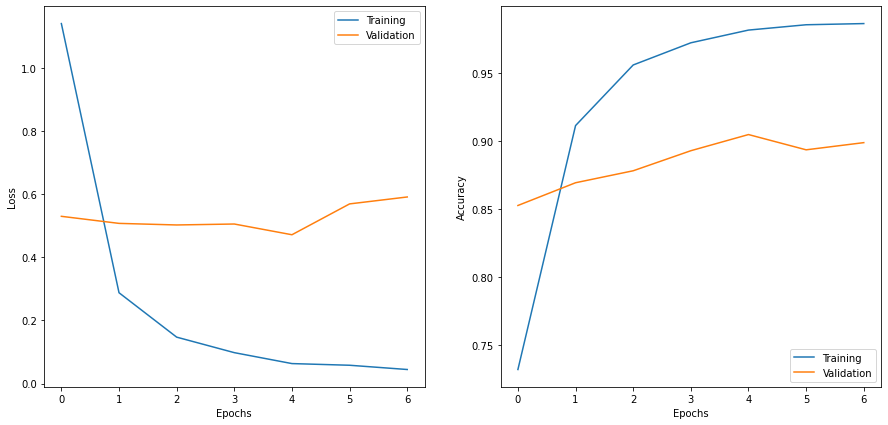

In [ ]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Training with Data Augmentation

In [ ]:
# Image transformations
train_processing_aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=30, brightness_range=[0.4,1.4],
                                                                horizontal_flip=True, vertical_flip=True,
                                                                zoom_range=[0.5,1.0],
                                                                preprocessing_function=xception.preprocess_input)

# Where to get the data and how to split them
train_generator_aug = train_processing.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


In [ ]:
test_processing_aug = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)
test_generator_aug = test_processing.flow_from_directory(
        directory=base_path+'test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 4544 images belonging to 102 classes.


In [ ]:
xception_model = xception.Xception(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

In [ ]:
# Number of layers
len(xception_model.layers)

133

In [ ]:
# Freezing layer learning
for layer in xception_model.layers:
    layer.trainable = False

In [ ]:
# Output of the base model
x = xception_model.output
# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
pred = keras.layers.Dense(102, activation='softmax')(x)

# Specialized model
net = keras.Model(inputs=xception_model.input, outputs=pred)


# Early Stopping per evitare l'overfit del modello e stoppare le epoche in automatico
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

In [ ]:
# Model training
history = net.fit(train_generator_aug,
                  epochs=100,
                  validation_data = test_generator,
                  callbacks = [es]);

Epoch 1/100
144/144 [==============================] - 49s 326ms/step - loss: 2.0570 - accuracy: 0.5825 - val_loss: 0.5475 - val_accuracy: 0.8473
Epoch 2/100
144/144 [==============================] - 45s 316ms/step - loss: 0.2734 - accuracy: 0.9200 - val_loss: 0.4945 - val_accuracy: 0.8682
Epoch 3/100
144/144 [==============================] - 46s 318ms/step - loss: 0.1254 - accuracy: 0.9601 - val_loss: 0.4972 - val_accuracy: 0.8856
Epoch 4/100
144/144 [==============================] - 46s 317ms/step - loss: 0.0703 - accuracy: 0.9817 - val_loss: 0.5197 - val_accuracy: 0.8886


In [ ]:
net.evaluate(test_generator)

142/142 [==============================] - 22s 158ms/step - loss: 0.5197 - accuracy: 0.8886


[0.5197271108627319, 0.8886443376541138]

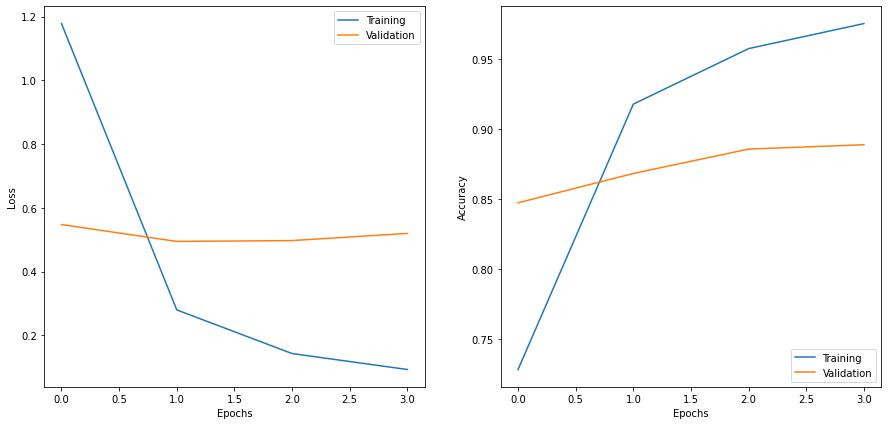

In [ ]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Conclusions
The models are very similar with a minimal difference.  
For the model without data Augmentation the accuracy is:
1. train accuracy = 0.9858
2. validation accuracy = 0.8985


For the model with data Augmentation the accuracy is:
1. train accuracy = 0.9817
2. validation accuracy = 0.8886

The best model is the one without data Augmentation even if they are practically identical.

The use of models with data augmentation reduces the overfitting but it has slightly worse performances